In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import re
from typing import *

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


### 1.Reading the data

In [2]:
data_path = Path("data/sarcasm/sarcasm.json")
df = pd.read_json(data_path)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [4]:
df['article_link'][0]

'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5'

In [5]:
def webapp_name(x):
    return re.findall(r'\.(.*?)\.', x)[0]


df['webapp_name'] = df['article_link'].apply(webapp_name)
df.head()

,article_link,headline,is_sarcastic,webapp_name
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


In [6]:
df['webapp_name'].value_counts(1)

webapp_name
huffingtonpost    0.561047
theonion          0.438953
Name: proportion, dtype: float64

In [7]:
# Converting each line to a list
sentences = df['headline'].to_list()
labels = df['is_sarcastic'].to_list()

In [8]:
sentences[:3], labels[:3]

(["former versace store clerk sues over secret 'black code' for minority shoppers",
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  "mom starting to fear son's web series closest thing she will have to grandchild"],
 [0, 0, 1])

### 2.Cleaning the Data

In [9]:
def clean_data(sentences: List[str]) -> List[str]:
    """
    Perform text cleaning on a list of sentences.

    Args:
        sentences (List[str]): List of input sentences.

    Returns:
        List[str]: List of cleaned sentences after applying stemming, lowercasing,
                   and removing stopwords.

    Note:
        This function uses the NLTK library for stemming and stopwords removal.
        Make sure to have NLTK installed (`pip install nltk`) and download the
        stopwords corpus using `nltk.download('stopwords')`.
    """
    ps = PorterStemmer()
    corpus = []

    for i in range(len(sentences)):
        each_sentence = re.sub('[^a-zA-Z]', ' ', sentences[i])
        each_sentence = each_sentence.lower()
        each_sentence = each_sentence.split()

        each_sentence = [ps.stem(word)
                         for word in each_sentence if word not in stopwords.words('english')]
        each_sentence = ' '.join(each_sentence)
        corpus.append(each_sentence)

    return corpus

* Each word contains only a to z in alphabets
* All stopwords are removed
* All words are converted to root word with help of PorterSTemmer

In [10]:
clean_sentences = clean_data(sentences)

In [11]:
clean_sentences[:3]

['former versac store clerk sue secret black code minor shopper',
 'roseann reviv catch thorni polit mood better wors',
 'mom start fear son web seri closest thing grandchild']

In [12]:
MAX_LENGTH = 0
for each_sentence in clean_sentences:
    temp_len = len(each_sentence)
    if MAX_LENGTH<temp_len:
        MAX_LENGTH = temp_len

print(MAX_LENGTH)

217


### 3.Train test Split

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    clean_sentences, labels, test_size=0.20, random_state=0, stratify=labels)

In [14]:
X_train[:3]

['share hazmat suit maker spike nyc ebola news',
 'miss america call u n council promot enough world peac',
 'tarsier world smallest primat anim planet looney front part']

In [15]:
pd.Series(y_train).value_counts(1)

0    0.561052
1    0.438948
Name: proportion, dtype: float64

In [16]:
pd.Series(y_test).value_counts(1)

0    0.561026
1    0.438974
Name: proportion, dtype: float64

### 4.Tokenization, Sequences and Padding

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of clean sentence is  217
# Giving 50 as the max length including the padded sequences
MAX_LENGTH = 50

# Output dimensions of the Embedding layer
EMBEDDING_DIM = 16

# Parameters for padding and OOV tokens
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOKEN = "<OOV>"

In [21]:
X_train[:3]

['share hazmat suit maker spike nyc ebola news',
 'miss america call u n council promot enough world peac',
 'tarsier world smallest primat anim planet looney front part']

In [22]:
def get_tokenizer(VOCAB_SIZE, OOV_TOKEN, X_data=X_train):
    # Initialize the Tokenizer class
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

    # Generate the word index dictionary
    tokenizer.fit_on_texts(X_data)
    
    return tokenizer

def to_sequences_n_padding(tokenizer,MAX_LENGTH,PADDING_TYPE,TRUNC_TYPE,X_data):
    # Generate and pad the training sequences
    _sequences = tokenizer.texts_to_sequences(X_data)
    _padded = pad_sequences(_sequences, 
                            maxlen=MAX_LENGTH, 
                            padding=PADDING_TYPE, 
                            truncating=TRUNC_TYPE)
    
    return _padded   

In [23]:
tokenizer = get_tokenizer(VOCAB_SIZE=VOCAB_SIZE,OOV_TOKEN=OOV_TOKEN)

training_padded = to_sequences_n_padding(tokenizer=tokenizer,
                                            MAX_LENGTH=MAX_LENGTH,
                                            PADDING_TYPE=PADDING_TYPE,
                                            TRUNC_TYPE=TRUNC_TYPE,
                                            X_data=X_train)
testing_padded = to_sequences_n_padding(tokenizer=tokenizer,
                                            MAX_LENGTH=MAX_LENGTH,
                                            PADDING_TYPE=PADDING_TYPE,
                                            TRUNC_TYPE=TRUNC_TYPE,
                                            X_data=X_test)

In [24]:
# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

In [25]:
training_padded.shape

(21367, 50)

In [26]:
testing_padded.shape

(5342, 50)

### 5. Dataset Preparation

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (training_padded, training_labels))
train_dataset = (train_dataset
                 .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

In [28]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    (testing_padded, testing_labels))
test_dataset = (test_dataset
                .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                .batch(32)
                .prefetch(tf.data.AUTOTUNE))

### 6. LSTM +BIDIRECTIONAL

##### Callbacks

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=0,
    mode='auto',
    # baseline=None,
    restore_best_weights=True,
    # start_from_epoch=0
)

# Saving the best model and its weights to given path
checkpoint_filepath = 'models/model_checkpoint_LSTM.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    # save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='auto'
)

##### Model Training

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH, name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, name="rnn1_30", return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, name="rnn2_50", return_sequences=False)),

    # tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(120, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),
    tf.keras.layers.Dropout(0.5, name="dropout1"),

    tf.keras.layers.Dense(80, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.4, name="dropout2"),


    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 60)            11280     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 100)               44400     
 onal)                                                           
                                                                 
 dense32 (Dense)             (None, 120)               12120     
                                                                 
 batch1 (BatchNormalization  (None, 120)               480       
 )                                                               
                                                      

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [37]:
history = model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=30,
          verbose=2,
          callbacks=[early_stopping, 
                     model_checkpoint_callback])

Epoch 1/30



Epoch 1: val_loss did not improve from 0.68567
668/668 - 48s - loss: 0.8238 - binary_accuracy: 0.5233 - val_loss: 0.7101 - val_binary_accuracy: 0.5651 - 48s/epoch - 73ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.68567 to 0.68352, saving model to models\model_checkpoint_LSTM.h5
668/668 - 31s - loss: 0.7868 - binary_accuracy: 0.5277 - val_loss: 0.6835 - val_binary_accuracy: 0.5839 - 31s/epoch - 46ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.68352 to 0.67786, saving model to models\model_checkpoint_LSTM.h5
668/668 - 34s - loss: 0.7649 - binary_accuracy: 0.5347 - val_loss: 0.6779 - val_binary_accuracy: 0.5917 - 34s/epoch - 51ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.67786 to 0.66748, saving model to models\model_checkpoint_LSTM.h5
668/668 - 32s - loss: 0.7318 - binary_accuracy: 0.5568 - val_loss: 0.6675 - val_binary_accuracy: 0.5977 - 32s/epoch - 48ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.66748
668/668 - 32s - loss: 0.7211 - binary_accurac

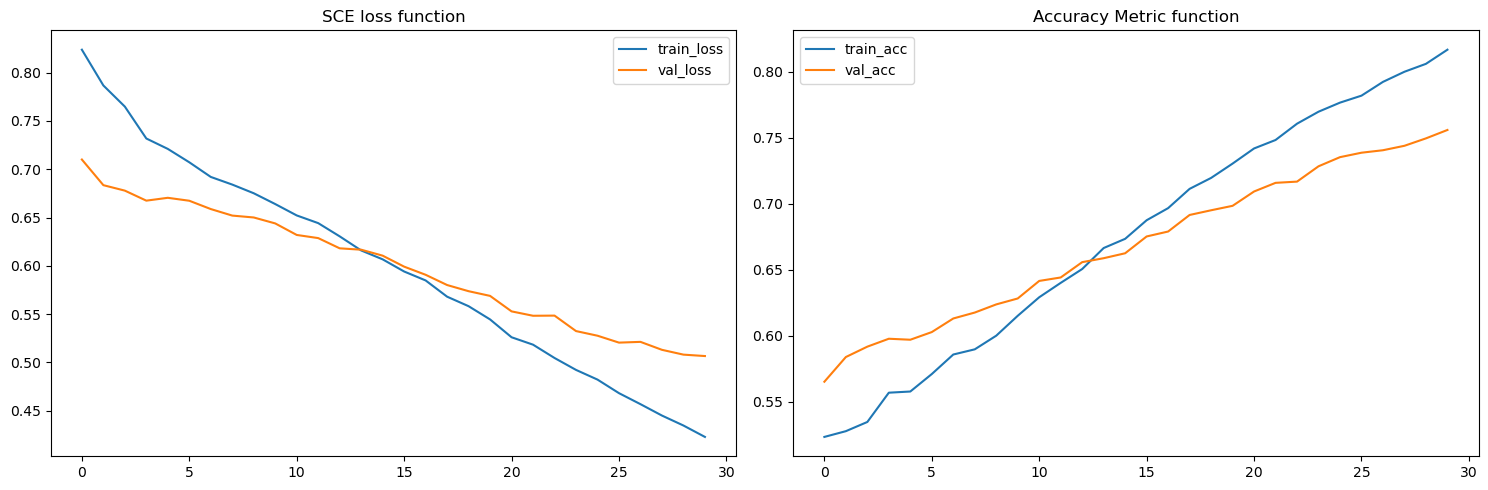

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['loss'], label="train_loss")
ax[0].plot(history.history['val_loss'], label="val_loss")
ax[0].set_title("SCE loss function")
ax[0].legend()

ax[1].plot(history.history['binary_accuracy'], label="train_acc")
ax[1].plot(history.history['val_binary_accuracy'], label="val_acc")
ax[1].set_title("Accuracy Metric function")
ax[1].legend()
plt.tight_layout()
plt.show()